# simplify clean

$
\begin{align}
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)G_t] \text{REINFORCE}\\
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)V_w(s)] \text{V actor-critic}\\
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)Q_w(s,a)] \text{Q actor-critic}\\
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)A_w(s,a)] \text{Advantage actor-critic}\\
\end{align}
$

## Q actor critic

In [1]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
from tools import discount_cumsum, run_experiment_episode_train

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
import tensorflow.keras.backend as K

In [5]:
class DeepAgent:                                                                                                                                                                                                
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .01):                                                                                                                          
        self.env = env                                                                                                                                                                                      
        self.is_deterministic = is_deterministic                                                                                                                                                            
        self.gamma = gamma                                                                                                                                                                                  
        self.epsilon = epsilon                                                                                                                                                                              
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
    def act(self, state):                                                                                                                                                                                   
        if self.is_deterministic:                                                                                                                                                                           
            action = np.argmax(self.policy[state])                                                                                                                                                          
        else:                                                                                                                                                                                               
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])                                                                                                              
            return action                                                                                                                                                                                       
        def train(current_state, action, reward, done):                                                                                                                                                         
            pass

In [6]:
import tensorflow.keras.backend as K

def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = K.sum(one_hot_action * K.log(action_probs) + (1 - one_hot_action) * K.log(1 - action_probs), axis=1)
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [16]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class QActorCriticAgent(DeepAgent):
    def __init__(self, env, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .01, alpha = .01, memory_size = 25):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model_actor()
        
        self.model.summary()
        
        self.model_critic = self._build_model_critic()
        
        self.model_critic.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        self.turn = 0
        

    def _build_model_actor(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.action_dim, activation='softmax')(x)
        model = Model(inputs=input_state, outputs=x)
        return model
    
    def _build_model_critic(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        if done is False:
            self.episode.append(np.array([current_state, action, reward, next_state, done]))#, reward + self.gamma * self.model_critic.predict(np.asarray(next_state).reshape(1,-1))]))
        else:
            self.episode.append(np.array([current_state, action, reward, next_state, done]))#, reward]))
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma).astype('float32')
            rewards = episode[:,2]
            dones = episode[:,4]
            X = np.vstack(episode[:,0])
            X_next = np.vstack(episode[:,3])
            Y = np.zeros((len(episode), self.action_dim))
            Y[np.arange(len(episode)), episode[:,1].astype(int)] = 1
            if len(self.episodes) == self.memory_size:
                Xs = np.vstack([ep[0] for ep in self.episodes])
                Ys = np.vstack([ep[1] for ep in self.episodes])
                Xs_next = np.vstack([ep[3] for ep in self.episodes])
                rewardss = np.hstack([ep[4] for ep in self.episodes])
                doness = np.hstack([ep[5] for ep in self.episodes])
                discounted_returns = np.hstack([ep[2] for ep in self.episodes])
                Ys_values = rewardss + (1 - doness) * self.model_critic.predict(Xs_next).ravel()
                #discounted_returns = np.hstack([ep[2] for ep in self.episodes])
                early_stopping = self.model_critic.train_on_batch(Xs, Ys_values.astype('float32'))
                print(early_stopping)
                baselines = rewardss + (1 - doness) * self.model_critic.predict(Xs_next).ravel() - self.model_critic.predict(Xs).ravel() 
                baselines -= baselines.mean()
                baselines /= baselines.std()
                loss = policy_gradient_loss(baselines.astype('float32'))
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-3))
                loss = self.model.train_on_batch(Xs,Ys)
                print('loss ', loss)
                #Y_values -= Y_values.mean()
                #Y_values /= Y_values.std()
                #discounted_returns -= discounted_returns.mean()
                #discounted_returns /= discounted_returns.std()
                #early_stopping = self.model_critic.train_on_batch(Xs,Y_values)
                self.episodes = []
            else:
                self.episodes.append([X,Y,discounted_return, X_next, rewards, dones])

    def save_model(self, path):
        self.model.save(path)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
________________________________________

episode: 206 - cum reward 16.0
1.0018365
loss  -0.13626537
episode: 207 - cum reward 17.0
episode: 208 - cum reward 45.0
episode: 209 - cum reward 28.0
episode: 210 - cum reward 36.0
episode: 211 - cum reward 14.0
episode: 212 - cum reward 35.0
episode: 213 - cum reward 21.0
episode: 214 - cum reward 20.0
episode: 215 - cum reward 17.0
episode: 216 - cum reward 19.0
episode: 217 - cum reward 13.0
episode: 218 - cum reward 26.0
episode: 219 - cum reward 12.0
episode: 220 - cum reward 25.0
episode: 221 - cum reward 18.0
episode: 222 - cum reward 33.0
episode: 223 - cum reward 15.0
episode: 224 - cum reward 37.0
episode: 225 - cum reward 30.0
episode: 226 - cum reward 36.0
episode: 227 - cum reward 18.0
episode: 228 - cum reward 8.0
episode: 229 - cum reward 15.0
episode: 230 - cum reward 29.0
episode: 231 - cum reward 28.0
episode: 232 - cum reward 16.0
1.0020596
loss  -0.1602754
episode: 233 - cum reward 24.0
episode: 234 - cum reward 15.0
episode: 235 - cum reward 35.0
episode: 236 - c

episode: 462 - cum reward 29.0
episode: 463 - cum reward 13.0
episode: 464 - cum reward 60.0
episode: 465 - cum reward 16.0
episode: 466 - cum reward 19.0
1.0007082
loss  -0.24962495
episode: 467 - cum reward 52.0
episode: 468 - cum reward 43.0
episode: 469 - cum reward 10.0
episode: 470 - cum reward 23.0
episode: 471 - cum reward 23.0
episode: 472 - cum reward 12.0
episode: 473 - cum reward 63.0
episode: 474 - cum reward 28.0
episode: 475 - cum reward 27.0
episode: 476 - cum reward 26.0
episode: 477 - cum reward 34.0
episode: 478 - cum reward 25.0
episode: 479 - cum reward 22.0
episode: 480 - cum reward 18.0
episode: 481 - cum reward 19.0
episode: 482 - cum reward 26.0
episode: 483 - cum reward 27.0
episode: 484 - cum reward 61.0
episode: 485 - cum reward 36.0
episode: 486 - cum reward 18.0
episode: 487 - cum reward 28.0
episode: 488 - cum reward 31.0
episode: 489 - cum reward 25.0
episode: 490 - cum reward 56.0
episode: 491 - cum reward 22.0
episode: 492 - cum reward 28.0
1.0004805
l

episode: 718 - cum reward 48.0
episode: 719 - cum reward 15.0
episode: 720 - cum reward 69.0
episode: 721 - cum reward 26.0
episode: 722 - cum reward 43.0
episode: 723 - cum reward 15.0
episode: 724 - cum reward 18.0
episode: 725 - cum reward 20.0
episode: 726 - cum reward 14.0
1.0000684
loss  -0.35448384
episode: 727 - cum reward 11.0
episode: 728 - cum reward 21.0
episode: 729 - cum reward 24.0
episode: 730 - cum reward 19.0
episode: 731 - cum reward 15.0
episode: 732 - cum reward 11.0
episode: 733 - cum reward 32.0
episode: 734 - cum reward 25.0
episode: 735 - cum reward 12.0
episode: 736 - cum reward 11.0
episode: 737 - cum reward 35.0
episode: 738 - cum reward 28.0
episode: 739 - cum reward 40.0
episode: 740 - cum reward 11.0
episode: 741 - cum reward 25.0
episode: 742 - cum reward 11.0
episode: 743 - cum reward 17.0
episode: 744 - cum reward 15.0
episode: 745 - cum reward 26.0
episode: 746 - cum reward 14.0
episode: 747 - cum reward 24.0
episode: 748 - cum reward 45.0
episode: 74

episode: 974 - cum reward 26.0
episode: 975 - cum reward 17.0
episode: 976 - cum reward 17.0
episode: 977 - cum reward 8.0
episode: 978 - cum reward 19.0
episode: 979 - cum reward 9.0
episode: 980 - cum reward 19.0
episode: 981 - cum reward 25.0
episode: 982 - cum reward 20.0
episode: 983 - cum reward 22.0
episode: 984 - cum reward 19.0
episode: 985 - cum reward 17.0
episode: 986 - cum reward 10.0
0.99801993
loss  -0.38952497
episode: 987 - cum reward 16.0
episode: 988 - cum reward 18.0
episode: 989 - cum reward 12.0
episode: 990 - cum reward 20.0
episode: 991 - cum reward 12.0
episode: 992 - cum reward 12.0
episode: 993 - cum reward 20.0
episode: 994 - cum reward 10.0
episode: 995 - cum reward 18.0
episode: 996 - cum reward 11.0
episode: 997 - cum reward 11.0
episode: 998 - cum reward 29.0
episode: 999 - cum reward 25.0


Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

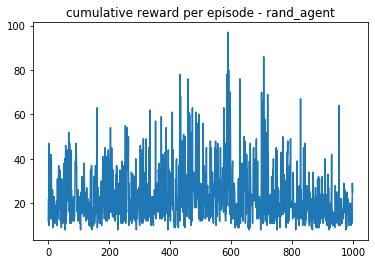

In [17]:
env = gym.make('CartPole-v0')
#env = gym.make('LunarLander-v2')
q_agent = QActorCriticAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 1000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [120]:
env = gym.make('LunarLander-v2')
q_agent = QActorCriticAgent(env, compiled_model=q_agent.model)
rewards = run_experiment_episode_train(env, q_agent, 800)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

Model: "model_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 8)]               0         
_________________________________________________________________
dense_342 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_343 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_344 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_345 (Dense)            (None, 4)                 132       
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________
Model: "model_113"
_________________________________________________________________
Layer (type)                 Output 

episode: 118 - cum reward -30.939273351842203
episode: 119 - cum reward 83.75108754642108
0.0910284429801067
-66.29582977294922
33.60968203840678
4.782722005987471
loss  -0.15136275
episode: 120 - cum reward -127.7296877413506
episode: 121 - cum reward -47.37488191119409
episode: 122 - cum reward -201.5246072866475
episode: 123 - cum reward -69.22632130061918
episode: 124 - cum reward -131.8582223879456
episode: 125 - cum reward -132.27978076841302
episode: 126 - cum reward -91.78998025289884
episode: 127 - cum reward -133.66091062907685
episode: 128 - cum reward -108.57776135791242
episode: 129 - cum reward -34.24535062213563
episode: 130 - cum reward -94.63917081117404
-0.0346758702405022
-20.359222412109375
63.897746147145824
2.5229538186706804
loss  -0.08508712
episode: 131 - cum reward -102.4606704593317
episode: 132 - cum reward 12.83033047133247
episode: 133 - cum reward -105.4859218398813
episode: 134 - cum reward -185.28300519797534
episode: 135 - cum reward 49.447321615503185

episode: 270 - cum reward -58.2075791028067
episode: 271 - cum reward -114.36150103688873
episode: 272 - cum reward -31.150895654663714
episode: 273 - cum reward -23.243892552802464
-0.04583874374263967
-94.40737533569336
17.210923539207332
2.4301084118632463
loss  -0.4204816
episode: 274 - cum reward -72.89728689894827
episode: 275 - cum reward -184.7719007078856
episode: 276 - cum reward -145.8524113738241
episode: 277 - cum reward -129.73092485475036
episode: 278 - cum reward -179.92326352818966
episode: 279 - cum reward -129.1591215854279
episode: 280 - cum reward -108.038797460422
episode: 281 - cum reward -130.1862740015889
episode: 282 - cum reward -114.42713079612862
episode: 283 - cum reward -153.33079076065547
episode: 284 - cum reward -130.78570338568795
-0.13302253232762848
-6.186378481815968
13.542862364550446
1.993552718304925
loss  -0.06656126
episode: 285 - cum reward -153.15787054447796
episode: 286 - cum reward -37.42036811570414
episode: 287 - cum reward 14.936145523

KeyboardInterrupt: 

In [ ]:
def policy_gradient_loss_continuous(returns):
    def modified_mse(action_true, action_pred):
        loss = -K.mean(returns * K.mean((action_true - action_pred)**2, axis=1))
        return loss
    return modified_mse

In [11]:
class DeepAgentContinuous:                                                                                                                                                                                                
    def __init__(self, env, gamma = .99, epsilon = .01):                                                                                                                          
        self.env = env                                                                                                                                                                                      
        self.gamma = gamma                                                                                                                                                                                  
        self.epsilon = epsilon                                                                                                                                                                              
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
    def act(self, state):                                                                                                                                                                                   
        pass
    def train(current_state, action, reward, done):                                                                                                                                                         
        pass 

In [17]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgentContinuous):
    def __init__(self, env, compiled_model = None, load_model_path = None, gamma = .99, epsilon = .01, alpha = .01, memory_size = 6):
        super().__init__(env, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        
        self.model.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        self.model_critic = self._build_model_critic()
        

    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.action_dim, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        return model
    
    def _build_model_critic(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2))
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.normal(prob)
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        if done is False:
            self.episode.append(np.array([current_state, action, reward, reward + self.gamma * self.model_critic.predict(np.asarray(next_state).reshape(1,-1))]))
        else:
            self.episode.append(np.array([current_state, action, reward, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma).astype('float32')
            X = np.vstack(episode[:,0])
            Y_value = np.vstack(episode[:,3])
            Y = np.vstack(episode[:,1])
            if len(self.episodes) == self.memory_size:
                Xs = np.vstack([ep[0] for ep in self.episodes])
                Ys = np.vstack([ep[1] for ep in self.episodes])
                Y_values = np.vstack([ep[3] for ep in self.episodes])
                discounted_returns = np.hstack([ep[2] for ep in self.episodes])
                early_stopping = self.model_critic.train_on_batch(Xs,Y_values)
                baselines = self.model_critic.predict(Xs)
                loss = policy_gradient_loss(discounted_returns)#baselines)
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
                self.episodes = []
            else:
                self.episodes.append([X,Y,discounted_return, Y_value])

    def save_model(self, path):
        self.model.save(path)

In [18]:
env = gym.make('LunarLanderContinuous-v2')
q_agent = ReinforceAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 8)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_31 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 66        
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward -558.0030592811014
episode: 1 - cum reward -627.1235896057083
episode: 2 - cum reward -478.171866270921
episode: 3 - cum reward -26.19963633216399
episode: 4 - cum reward -523.9392390330768
episode: 5 - cum reward -200.39749380120

KeyboardInterrupt: 